In [25]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


In [26]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

In [27]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['m_1']

# Edit region -------------

physical_parameters_symbols = {'m_1': '$m$'}
no_of_params = len(physical_parameters)
domain = HyperParalelipiped(bounds=[[0, 1]], fineness=1000)
constituent_models_spaces = [PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

In [28]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 100
# Edit region -------------

D = RN(dimension=how_many_data)

In [29]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        if i in [0, 2]:
            sensitivity_dict[param].append(NormalModes_1D(domain=domain, order=5, spread=0.02,
                                                        max_freq=30, seed=index + i*how_many_data))
        else:
            sensitivity_dict[param].append(NormalModes_1D(domain=domain, order=3, spread=0.1,
                                                        max_freq=10, seed=index + i*how_many_data, 
                                                        no_sensitivity_regions=[[0.5, 0.75]]))

constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

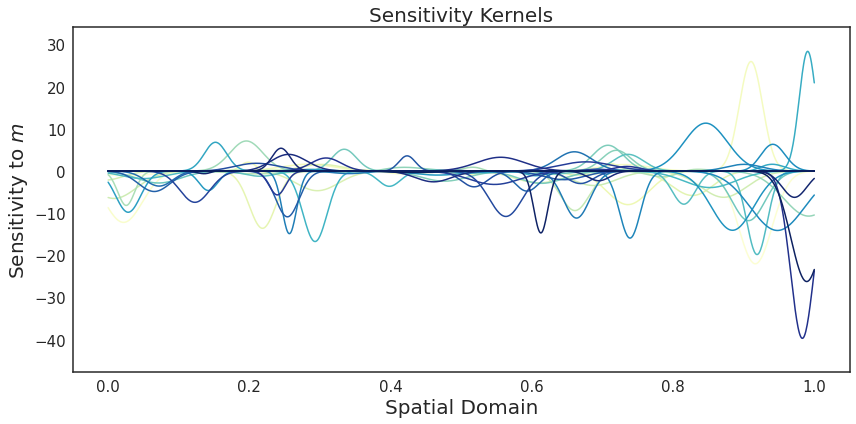

In [30]:
%matplotlib inline
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')
    
    for j, kernel in enumerate(sensitivity_dict[param]):
        y_values = kernel.evaluate(domain.mesh)[1]  # Extract y-values from the kernel data
        
        # Update y_min and y_max based on current kernel's data
        y_min = min(y_min, np.min(y_values))
        y_max = max(y_max, np.max(y_values))
        
        axes.plot(domain.mesh, y_values, color=colors[int(100*j/how_many_data)])
    y_min *= 1.2
    y_max *= 1.2
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.set_ylim([y_min, y_max])
    axes.set_ylabel('Sensitivity to ' + physical_parameters_symbols[param], fontsize=20)

# Adjust fontsize for ticks
axes.set_title('Sensitivity Kernels', fontsize=20)
axes.set_xlabel('Spatial Domain', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('kernels_for_fourier.png', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'m_1': Fourier}
orders = np.arange(0,15,1,dtype=int)
how_many_targets = 2*len(orders) - 1
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Fourier: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            if i == 0:
                target = target_type(domain=domain,type='cos', order=0)
            elif (i % 2 == 1):
                target = target_type(domain=domain,type='sin', order=int(i/2)+1)
            else:
                target = target_type(domain=domain,type='cos', order=i/2)
            targets_dict[param].append(target)
        else: 
            targets_dict[param].append(target_type(domain=domain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

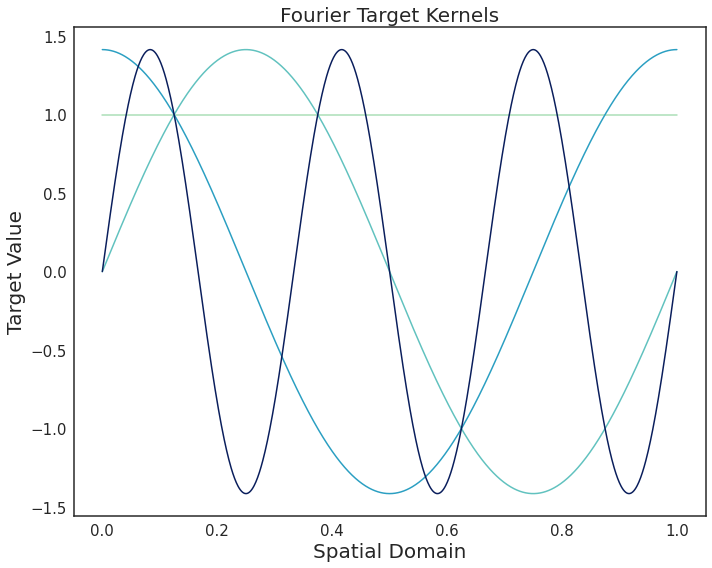

In [32]:
%matplotlib inline
plt.figure('Targets', figsize=(10,8))
for index in [0,1,2,5]:
    plt.plot(domain.mesh, targets_dict[param][index].evaluate(domain.mesh)[1],
            color=colors[int(70*index/5 + 30 - 1)])
plt.title('Fourier Target Kernels', fontsize=20)
plt.xlabel('Spatial Domain', fontsize=20)
plt.ylabel('Target Value', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Fourier_targets.png', bbox_inches='tight', dpi=300)
plt.show()

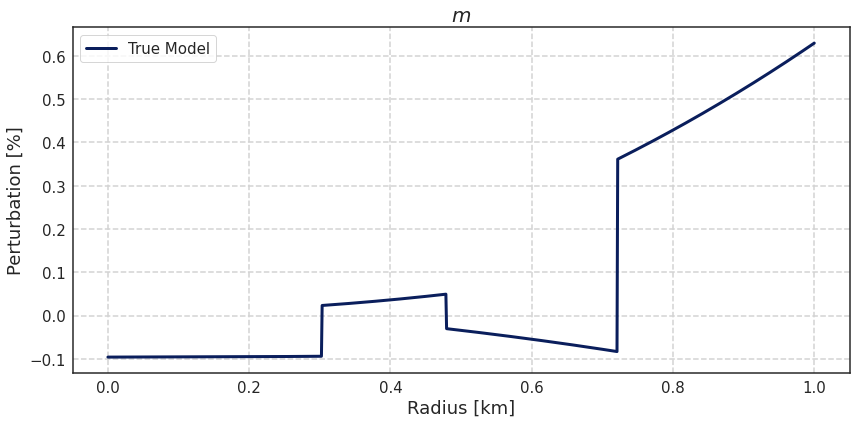

In [33]:

#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes.plot(domain.mesh, submodel.evaluate(domain.mesh)[1], 
            label='True Model', color=colors[99], linewidth=3)
    axes.set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes.set_xlabel('Radius [km]', fontsize=18)
    axes.set_ylabel('Perturbation [%]', fontsize=18)
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

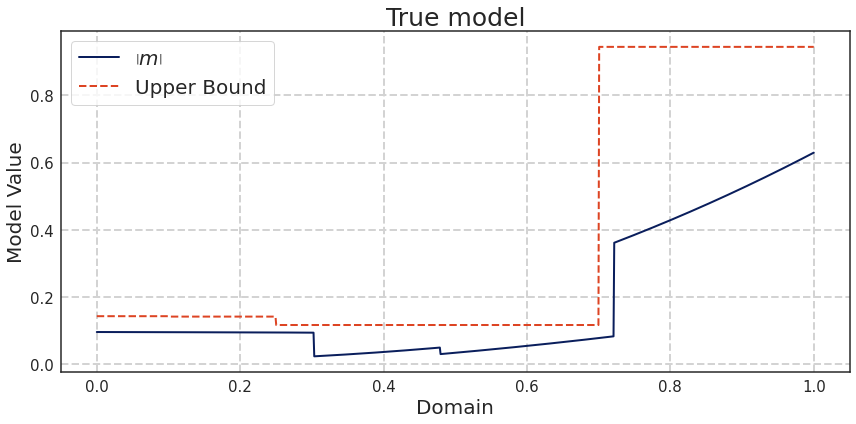

In [34]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,0.1, 0.25, 0.7, domain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:])[1])*1.5
    upper_bound = Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes.plot(domain.mesh, np.abs(submodel.evaluate(domain.mesh)[1]), 
             label=r'$\left| m \right|$', color=colors[99], linewidth=2)
    axes.plot(domain.mesh, upperbound.evaluate(domain.mesh)[1], 
             label='Upper Bound', color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes.set_ylabel('Model Value', fontsize=20)
    # Set tick parameters
    axes.tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=2, color='lightgray')  # Add gridlines
    axes.legend(fontsize=20)
plt.title('True model', fontsize=25)
plt.xlabel('Domain', fontsize=20)
plt.tight_layout()
plt.savefig('bound_fourier.png', bbox_inches='tight')
plt.show()

In [35]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

In [36]:
print(norm_bound)

0.5275772732695274


In [37]:
problem.solve()

In [38]:
problem._compute_least_norm_property()

In [39]:
# Compute True property
true_property = T.map(true_model)
print(true_property)

[[ 0.10034487]
 [-0.13210341]
 [ 0.10441357]
 [-0.1487484 ]
 [ 0.01105722]
 [-0.02717049]
 [-0.02068214]
 [-0.02337683]
 [ 0.00926417]
 [-0.04948969]
 [ 0.01739316]
 [-0.03626761]
 [-0.01103964]
 [-0.0054473 ]
 [-0.00484189]
 [-0.02254444]
 [ 0.00957338]
 [-0.02879162]
 [ 0.00491767]
 [-0.01219706]
 [-0.01155445]
 [-0.00733599]
 [ 0.00333332]
 [-0.01968469]
 [ 0.00738613]
 [-0.01637994]
 [-0.0029177 ]
 [-0.0054181 ]
 [-0.0070864 ]]


In [40]:
# Compute fake inverse
""" aa = np.dot(problem.Gamma.matrix, problem.Gamma.matrix.T)
aa_inv = ImplicitInvFiniteLinearMapping(domain=P, codomain=P, inverse_matrix=aa)
pp = problem.Gamma.map(data)
sol = aa_inv.map(pp) """

' aa = np.dot(problem.Gamma.matrix, problem.Gamma.matrix.T)\naa_inv = ImplicitInvFiniteLinearMapping(domain=P, codomain=P, inverse_matrix=aa)\npp = problem.Gamma.map(data)\nsol = aa_inv.map(pp) '

In [41]:
sol = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]


/tmp/ipykernel_6479/466452786.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]


In [42]:
my_sol = problem.T_adjoint.map(problem.least_norm_property)[0]
other_sol = problem.T_adjoint.map(sol)
projected_sol = problem.T_adjoint.map(true_property)

In [43]:
data_proj = G.map(projected_sol)

In [44]:
sol_proper = np.linalg.lstsq(problem.Gamma.matrix.T, data_proj)[0]

/tmp/ipykernel_6479/219411653.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol_proper = np.linalg.lstsq(problem.Gamma.matrix.T, data_proj)[0]


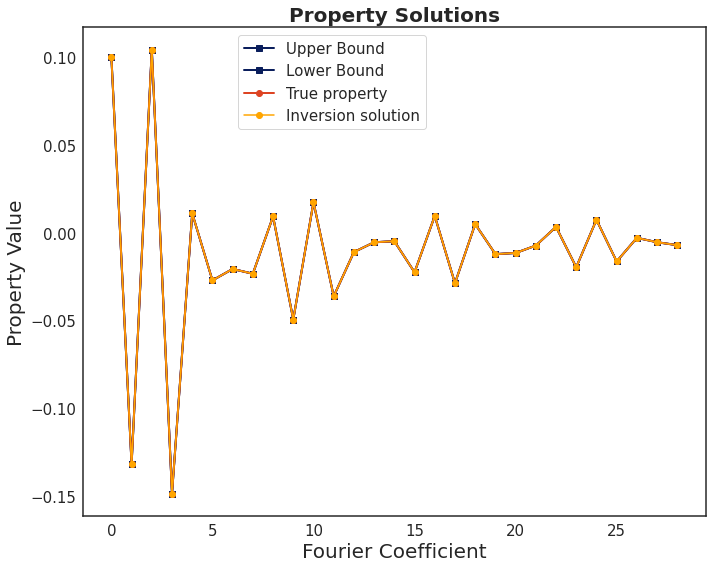

In [45]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.max(true_property)*1.5
y_min = np.min(true_property)*1.5
enquiry_points = np.arange(0, how_many_targets)
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set_style(style='white')  # Set seaborn style
plt.title('Property Solutions', fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99], 
         linewidth=2, label='Upper Bound', marker='s')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99], 
         linewidth=2, label='Lower Bound', marker='s')  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', 
         linewidth=2, label='True property', marker='o')
plt.plot(enquiry_points, sol_proper, color='orange', marker='o',
            label='Inversion solution')
#plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.4, 1))

plt.xlabel('Fourier Coefficient', fontsize=20)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=20)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_theory.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

In [46]:
upper_bounds = problem.solution['upper bound']
lower_bounds = problem.solution['lower bound']
upper_bounds = [item for sublist in upper_bounds for item in sublist]
lower_bounds = [item for sublist in lower_bounds for item in sublist]

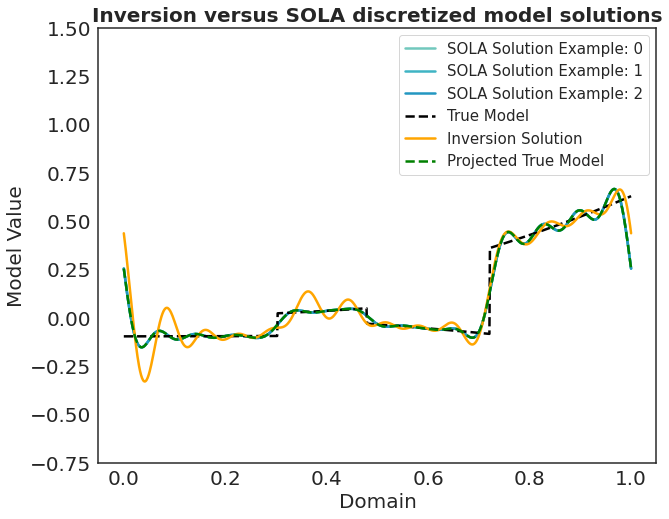

In [47]:
plt.figure('new_theory', figsize=(10,8))
for index in range(3):
    samples = []
    for upper, lower in zip(upper_bounds, lower_bounds):
        sample = random.uniform(lower, upper)
        samples.append(sample)
    samples = np.array(samples).reshape((len(samples), 1))
    my_sol = problem.T_adjoint.map(samples)

    plt.plot(domain.mesh, my_sol[0].evaluate(domain.mesh)[1], 
             color=colors[int(60*index/6 + 40)], linewidth=2.5,
             label='SOLA Solution Example: ' + str(index))

plt.plot(domain.mesh, true_model[0].evaluate(domain.mesh)[1], 
        color='black', label='True Model', linestyle='dashed',
        linewidth=2.5)
plt.plot(domain.mesh, other_sol[0].evaluate(domain.mesh)[1], 
        color='orange', label='Inversion Solution', linewidth=2.5)
plt.plot(domain.mesh, projected_sol[0].evaluate(domain.mesh)[1], 
        color='green', label='Projected True Model', linestyle='dashed',
        linewidth=2.5)
plt.ylim([-0.75,1.5])
plt.title('Inversion versus SOLA discretized model solutions', fontsize=20,
        fontweight='bold')
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Domain', fontsize=20)
plt.ylabel('Model Value', fontsize=20)
plt.savefig('discretized_model.png', dpi=300, bbox_inches='tight') 
plt.show()

In [48]:
print(np.where(np.isnan(upper_bounds)))

(array([], dtype=int64),)
